# **Procesado básico de la señal: Muestreo**
## Procesamiento de Imagen y Señal
### **Alan García Justel**
### Curso 2024-2025

In [1]:
import math
import cmath

import os
import sys

##

import warnings
warnings.filterwarnings('ignore')

##

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.image as im

from scipy import signal, fftpack, ndimage
from scipy.fft import fft, ifft

import scipy.signal as sp_s
import scipy.io as sp_io

from scipy.signal import chirp, spectrogram
from scipy.io import wavfile

### Audio
from IPython.display import Image, HTML, display
import IPython.display as ipd
import librosa
import librosa.display

from pydub import AudioSegment
from pydub.effects import normalize
from pydub.playback import play

import soundfile as sf

#### Important tips
# To hear the signal
# ipd.Audio(x, rate=fs)
####

### Image
from PIL import Image

from skimage import io, transform

In [ ]:
sys.path.append(os.getcwd())

# Funciones auxiliares
path = "code/"

# Add the directory containing your module to the Python path (wants absolute paths)
sys.path.append(os.path.abspath(path))

from f_audio_player_list import *

from f_plot import *
from f_get_random import *

In [2]:
# Plot two,three and four images side by side

def plot2(s1, s2, c1=None, c2=None):
    image1 = im.imread(s1)
    image2 = im.imread(s2)

    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(15,10))

    ax1.set_title(c1)
    ax1.imshow(image1)
    ax2.set_title(c2)
    ax2.imshow(image2)
    plt.show()

---

# **Muestreo y *Aliasing***

Cuando se obtienen muestras periódicas de una señal sinusoidal, puede ocurrir que se obtengan las mismas muestras que se obtendrían de una señal sinusoidal igual pero con frecuencia más baja.

Un ejemplo, si una sinusoide de frecuencia $f$ Hz se muestrea $s$ veces por segundo, y $s \leq 2 f$, entonces las muestras resultantes también serán compatibles con una sinusoide de frecuencia $f_{m}-f$, donde $f_{m}$ es la frecuencia de muestreo. 

En este caso, cada una de las sinusoides se convierte en un "alias" para la otra.

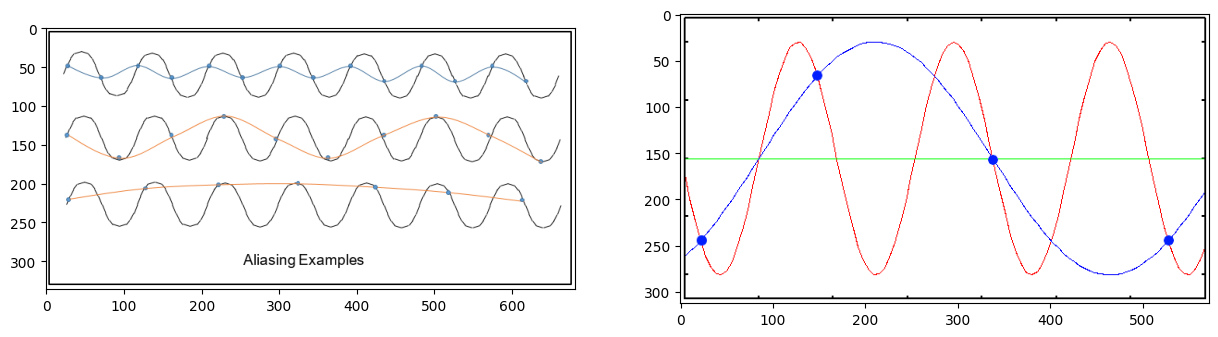

In [3]:
plot2("images/aliasing-examples.png", "images/Aliasing-plot.png")

<hr style="border: 1px solid pink" />

1. Elige una de las siguientes cuestiones:
   * (**Grupo 1**) Genera la señal $x(t)=sin(t \cdot \pi)$ donde $t \in \lbrack 0, 100 \rbrack$. 
      1. Visualiza $10000$ muestras de la función.
      2. Visualiza $100$ muestras de este muestreo previo con un paso de $100$, $101$ y $102$ unidades.
   * (**Grupo 2**) Obtén una señal “tren de impulsos” cada $5$ elementos y muestrea la señal cada $5$ elementos (unas $50-60$ muestras). Visualiza tanto la señal original como la señal muestreada.
   * (**Grupo 3**) Genera la señal $x(t)=sin(t)$ y muestrea la señal cada $5$ elementos (unas $50-60$ muestras). Visualiza tanto la señal original como la señal muestreada.

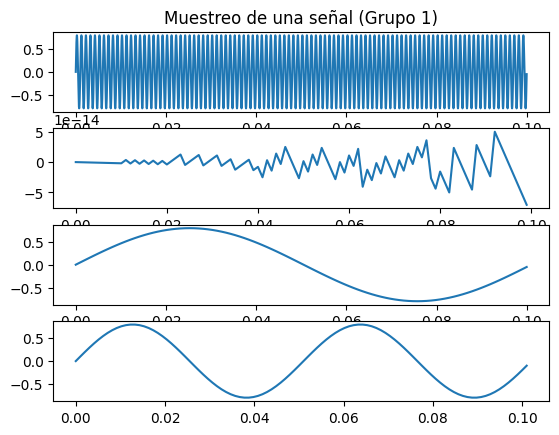

In [15]:
# Grupo 1
A           = 0.8   # Amplitud de la señal base
f           =1000   # Hz
duracion    = 1.0   # s

t = np.arange(0.0, duracion, 0.00001)
y = A * np.sin(2*np.pi * f * t)     # Señal sinusoidal 

f, axs = plt.subplots(4)
axs[0].set_title("Muestreo de una señal (Grupo 1)")
axs[0].plot(t[:10000], y[:10000])      # graficar 10000 muestras
axs[1].plot(t[::100][:100], y[::100][:100])      # graficar 100 muestras con un paso de 100
axs[2].plot(t[::101][:100], y[::101][:100])      # graficar 100 muestras con un paso de 101
axs[3].plot(t[::102][:100], y[::102][:100])      # graficar 100 muestras con un paso de 102
# Se puede observar que dependiendo de la frecuencia de muestreo, la señal resultante varía
# considerablemente de la original




<hr style="border: 1px solid green" />

2. ¿ Qué sucede cuando muestramos mal una señal ? Veamos un ejemplo. Lee la señal `audio_pipeline/samoyed-shambles.wav` y crea tres señales a partir de ella:
    + La señal `samoyed_4kHz` con una frecuencia de muestreo de $4000$ Hz.
    + La señal `samoyed_8kHz` con una frecuencia de muestreo de $8000$ Hz.
    + La señal `samoyed_16kHz` con una frecuencia de muestreo de $16000$ Hz.
    + La señal `samoyed_32kHz` con una frecuencia de muestreo de $32000$ Hz.

    ¿ Cuál es la frecuencia de muestreo de la señal original ?

   22050Hz

    Nota: Guarda las señales creadas en el directorio `www/`.

In [20]:
# Lee la señal, remuestreala y oye las señales. 
# Además, cuál es la frecuencia de muestreo de la señal original.

fn_wav = os.path.join('audio_pipeline', 'samoyed-shambles.wav')
audio, sr = librosa.load(fn_wav)
print(f"Frecuencia de muestreo de la señal original: {sr}")
ipd.display(ipd.Audio(data=audio, rate=sr))

for sr in [32, 16, 8, 4]:
    sr *= 1000
    audio, sr = librosa.load(fn_wav, sr=sr)
    ipd.display(ipd.Audio(data=audio, rate=sr))


Frecuencia de muestreo de la señal original: 22050


<hr style="border: 1px solid green" />

3. Muestrea una de las siguientes señales (elegida aleatoriamente):
   1. Señal con una frecuencia de muestreo de $200$ Hz.
   $$x(t)=4 + 4 \sin(350 \pi t) + 2 \cos \left(150 \pi t + \frac{\pi}{3} \right)$$
   2. Utiliza unas $200$, $400$ y $800$ muestras en el intervalo $[-1,1]$ para muestrear la señal:
   $$x(t) = sin(2 \pi \cdot 0.75t  \cdot (1 - t) + 2.1) + \\ 0.1  \cdot sin(2 \pi \cdot 1.25t + 1) + 0.18 \cdot cos(2 \pi  \cdot 3.85t)$$
   3.Señal con una frecuencia de muestreo de $12$ kHz y $24$ kHz. Visualiza las señales en el intervalo $[-0.005, 0.005]$.
   $$x(t) = 10 \cdot cos(2 \pi \cdot 1000 t) + 6 \cdot cos(2 \pi \cdot 2000 t) + 2 \cdot cos(2 \pi \cdot 4000 t)$$


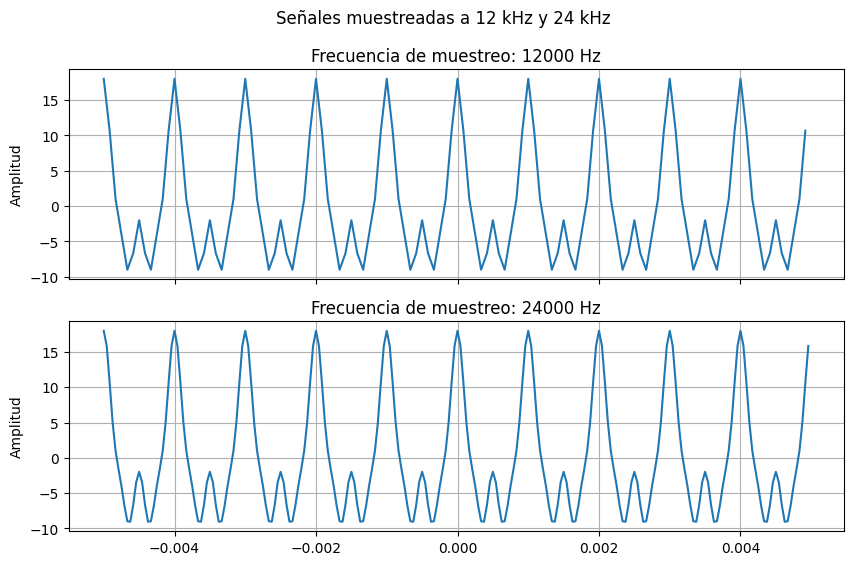

In [24]:
# Genera la señal y realiza la tarea (3)
frec_muestreo = [12000, 24000]  # Frecuencias de muestreo
intervalo = [-0.005, 0.005]     # Intervalo de tiempo en segundos

f, axs = plt.subplots(len(frec_muestreo), figsize=(10, 6), sharex=True)
f.suptitle("Señales muestreadas a 12 kHz y 24 kHz")

for i, fs in enumerate(frec_muestreo):
    t = np.linspace(intervalo[0], intervalo[1], int(fs * (intervalo[1] - intervalo[0])), endpoint=False)
    y = 10 * np.cos(2 * np.pi * 1000 * t) + 6 * np.cos(2 * np.pi * 2000 * t) + 2 * np.cos(2 * np.pi * 4000 * t)
    axs[i].plot(t, y)
    axs[i].set_title(f"Frecuencia de muestreo: {fs} Hz")
    axs[i].set_ylabel("Amplitud")
    axs[i].grid()

# Se visualizan igual. Con 12kHz serría suficiente

<hr style="border: 1px solid green" />

4. Obtén los primeros cuatro valores de la muestra de las siguientes funciones:
   1. Si la función $x(t)=3 cos(6 \pi t)$ se muestrea cada $0.5$ segundos a partir del instante $t=0$
   2. Si la función $x(t)=3 sin \left(\left(t-\frac{1}{2}\right) \pi \right)$ se muestrea cada $0.5$ segundos a partir del instante $t=1$

   ¿ Cuáles serán los primeros cuatro valores muestreados ?

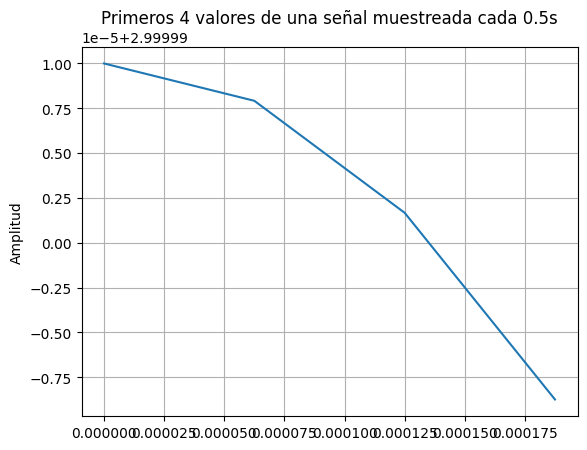

In [52]:
# (1)
frec_muestreo = 1/0.5   # Frecuencias de muestreo
duration = 1.0          # Duración de la señal en segundos

t = np.linspace(0.0, duration, int(fs*duration), endpoint=False)
y = 3 * np.cos(6 * np.pi * t)

plt.title("Primeros 4 valores de una señal muestreada cada 0.5s")
plt.plot(t[:4], y[:4])
plt.ylabel("Amplitud")
plt.grid()

<hr style="border: 1px solid green" />

5. ¿ Cuál es la frecuencia Nyquist y el intervalo de Nyquist de las siguientes señales:
   * señal vocal que contiene frecuencias de hasta $4$ kHz
   * señal de audio que posee frecuencias de hasta $20$ kHz
  
   Solución:

   Para el primer caso, la frecuencia Nyquist de $4$ kHz sería $8.4$ kHz (el doble más el $10$%).
   Para el segundo caso serían $42$kHz.

* Para muestrear una señal vocal que contenga frecuencias de hasta $4$ kHz, la frecuencia de Nyquist debe ser, de al menos, 8 kHz y el intervalo de Nyquist (intervalo de tiempo máximo Ts) es 1/fs = 1/8 kHz = 0,125 ms.
* Para muestrear una señal de audio que posea frecuencias de hasta 20 kHz, la frecuencia de Nyquist debe ser de, al menos, 40 kHz y el intervalo de Nyquist es 1/fs = 1/40 kHz = 25 $\mu$ s

<hr style="border: 1px solid green" />

6. Para las siguientes señales, indica cuál es la tasa de muestreo $f_{s}$ mínima que deberíamos utilizar para muestrear sin perder información.
   1. Función $7+5 cos(2 \pi 440 t) + 3 sin(2 \pi 880 t)$
   2. Función $7+5 sin(2 \pi 440 t) + 3 cos(2 \pi 880 t)$
   3. Función $7+5 cos(2 \pi 440 t) + 3 cos(2 \pi 880 t)$
   4. Función $7+5 sin(2 \pi 440 t) + 3 sin(2 \pi 880 t)$
   5. Función $2+0.5 cos(40 \pi t) + 0.25 sin(100 \pi t)$
   6. Función $2+0.5 sin(40 \pi t) + 0.25 cos(100 \pi t)$
   7. Función $2+0.5 sin(40 \pi t) + 0.25 sin(100 \pi t)$
   8. Función $2+0.5 cos(40 \pi t) + 0.25 cos(100 \pi t)$

In [54]:
# Realiza la tarea (3)
# Frecuencia máxima 880 -> fs minima para no perder información: 1760Hz

# Ten en cuenta que hay que dividir por 2*pi para pasarlo a Hz

<hr style="border: 1px solid green" />

7. Visualiza la función potencia:

    $$x(n) = 0.9^{\lvert n \rvert}$$

    donde el índice para las muestras $n$ solo toma valores enteros.

    El muestreo para cada valor $n$ se establece en el intervalo $[0, m)$ para $m$ muestras con una frecuencia angular $\omega_{0}= 2\pi f = \frac{2\pi}{12}$ radianes/segundo.

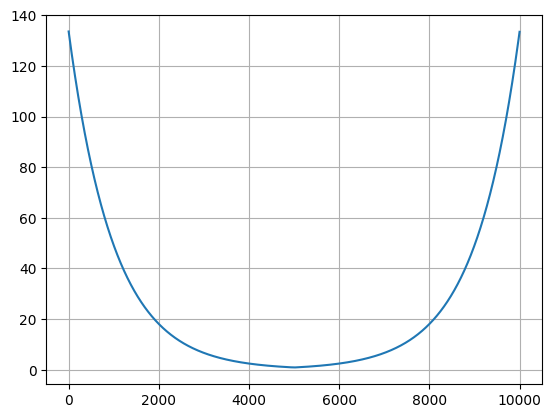

In [57]:
# Realiza la tarea

n = np.arange(-5.0, 5.0, 0.001)
x = 0.9*np.exp(abs(n))

plt.plot(x)
plt.grid()


<hr style="border: 1px solid green" />

8.  Remuestreo de una señal de audio según tu grupo:
     1. `audio_voz/speech0.wav`
     2. `audio_voz/speech1.wav`
     3. `audio_voz/speech2.wav`
     4. `audio/test_sampling.wav`
     
     <br>

    * Determina el número total de muestras, el número de bits por muestra y la frecuencia de muestreo de la señal mediante la función [**`info()`**](https://python-soundfile.readthedocs.io/en/0.11.0/#soundfile.info) de la librería `soundfile`.
    * Lee el archivo con la función [**`read()`**](https://python-soundfile.readthedocs.io/en/0.11.0/#read-write-functions) de la librería `soundfile` y reproduce el sonido a la frecuencia normal. 
    * Muestrea valores alternos de la señal y reproduce a la mitad de la frecuencia.
    * Muestrea cada cuarto valor de la señal y reproduce a un cuarto de la frecuencia.
    * Toma muestras de cada octavo valor de la señal y reproduce a un octavo de la frecuencia.

In [42]:
# Realiza la tarea
file_path = os.path.join('audio_voz', 'speech0.wav')

# Info
data = sf.info(file_path)
num_muestras = data.duration * data.samplerate
print(data)
print(f"Número total de muestras: {num_muestras}")

# Cargar y escuchar el audio con distintas frecuencias de muestreo
audio, sr = sf.read(file_path)
ipd.display(ipd.Audio(data=audio, rate=sr))             # original
ipd.display(ipd.Audio(data=audio[::2], rate=sr // 2))   # 1/2 frec muestreo
ipd.display(ipd.Audio(data=audio[::4], rate=sr // 4))   # 1/4 frec muestreo
ipd.display(ipd.Audio(data=audio[::8], rate=sr // 8))   # 1/8 frec muestreo

audio_voz/speech0.wav
samplerate: 48000 Hz
channels: 1
duration: 7.105 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]
Número total de muestras: 341033.0


<hr style="border: 1px solid green" />

9. Muestrea la siguiente señal analógica:
        $$x(t) = 10 cos(2 \pi 1000 t) + 6 cos(2 \pi 2000 t) + 2 cos(2 \pi 4000 t)$$
con diferentes frecuencias de muestreo $fs = 4, 5, 8$ kHz y observa el *aliasing* de la señal.
    + Caso 1: fs = 4KHz
    + Caso 2: fs = 5KHz
    + Caso 3: fs = 8KHz

    Cuando una señal se muestrea a una frecuencia inferior al doble de la frecuencia máxima de la señal, puede producirse *aliasing*, lo que significa que el espectro de la señal original se pliega y sus imágenes se solapan con el espectro real, afectando así a la amplitud de las distintas frecuencias. Por lo tanto, la secuencia original no se puede reconstruir.

    Indica qué sucede en los diferentes casos:

    Se produce un efecto de aliasing. La frecuencia máxima de la señal es de 8kHz, luego al muestrear por debajo del doble (16kHz) se puede observar cómo existe una pérdida de información (bordes "bruscos" en la señal)

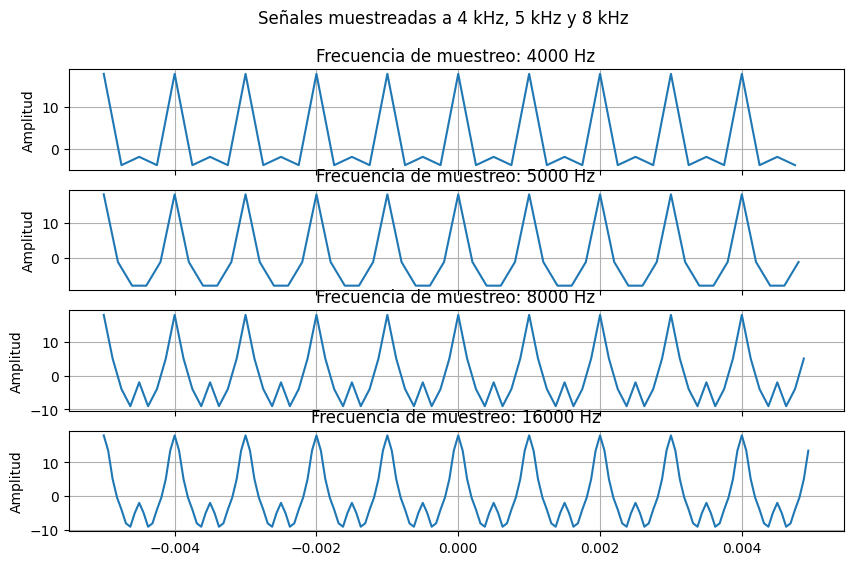

In [31]:
frec_muestreo = [4000, 5000, 8000, 16000]  # Frecuencias de muestreo
intervalo = [-0.005, 0.005]     # Intervalo de tiempo en segundos

f, axs = plt.subplots(len(frec_muestreo), figsize=(10, 6), sharex=True)
f.suptitle("Señales muestreadas a 4 kHz, 5 kHz y 8 kHz")

for i, fs in enumerate(frec_muestreo):
    t = np.linspace(intervalo[0], intervalo[1], int(fs * (intervalo[1] - intervalo[0])), endpoint=False)
    y = 10 * np.cos(2 * np.pi * 1000 * t) + 6 * np.cos(2 * np.pi * 2000 * t) + 2 * np.cos(2 * np.pi * 4000 * t)
    axs[i].plot(t, y)
    axs[i].set_title(f"Frecuencia de muestreo: {fs} Hz")
    axs[i].set_ylabel("Amplitud")
    axs[i].grid()